<a href="https://colab.research.google.com/github/sijuswamy/Test/blob/main/Stock_price_prediction_using_RNN%2C_LSTM_and_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* [1. Loading Data](#1) <br>
* [2.Spliting Data as Train and Validation](#2) <br>
* [3.Creating Train Dataset from Train split](#3) <br>
* [4.Normalization / Feature Scaling](#4) <br>
* [5.Creating X_train and y_train from Train data](#5) <br>
* [6.Creating Simple RNN model](#6) <br>
* [7.Evaluating Model](#7) <br>
* [8.Creating Test Dataset from Validation Data](#8) <br>
* [9.Evaluating with Validation Data](#9) <br>
* [10.Creating LSTM model](#10) <br>
* [11.Evaluating LSTM model](#11) <br>
* [12.Future price prediction](#12) <br>


<a id="1"></a>
## 1.Loading Data

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
data1 = pd.read_csv('https://raw.githubusercontent.com/sijuswamy/Test/refs/heads/main/Google_Stock_Price_Train.csv')
data2=pd.read_csv('https://raw.githubusercontent.com/sijuswamy/Test/refs/heads/main/Google_Stock_Price_Test.csv')
data=pd.concat([data1,data2])

In [24]:
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1278 non-null   object 
 1   Open    1278 non-null   float64
 2   High    1278 non-null   float64
 3   Low     1278 non-null   float64
 4   Close   1278 non-null   object 
 5   Volume  1278 non-null   object 
dtypes: float64(3), object(3)
memory usage: 102.2+ KB


<a id="2"></a>
## 2.Spliting Data as Train and Validation

In [26]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 1278
Train data length : 895
Validation data lenth : 383


In [27]:
train_data = data[:length_train].iloc[:,:2]
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Open
0,2012-01-03,325.25
1,2012-01-04,331.27
2,2012-01-05,329.83
3,2012-01-06,328.34
4,2012-01-09,322.04
...,...,...
890,2015-07-20,659.24
891,2015-07-21,655.21
892,2015-07-22,660.89
893,2015-07-23,661.27


In [28]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Open
895,2015-07-27,621.00
896,2015-07-28,632.83
897,2015-07-29,628.80
898,2015-07-30,630.00
899,2015-07-31,631.38
...,...,...
15,2017-01-25,829.62
16,2017-01-26,837.81
17,2017-01-27,834.71
18,2017-01-30,814.66


<a id="3"></a>
## 3.Creating Train Dataset from Train split

* We will get Open column as our dataset
* Dataset to be converted to array by adding `.values`

In [30]:
dataset_train = train_data.Open.values
dataset_train.shape

(895,)

## Changing this sequence in to an array

In [31]:
# Change 1d array to 2d array
# Changing shape from (881,) to (881,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(895, 1)

#### <a id="4"></a>
## 4.Normalization / Feature Scaling

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(895, 1)

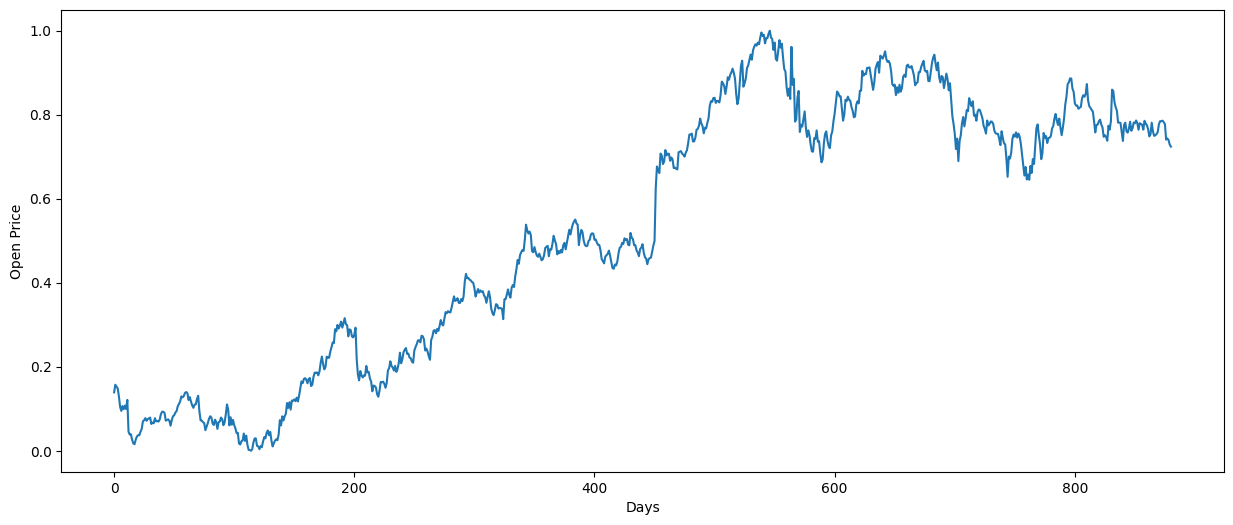

In [10]:
# visualizing training data
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days")
plt.ylabel("Open Price")
plt.show()

* We have train data composed of stock open prices over days
* So, it has 881 prices corresponding 881# days
* My aim is to predict the open price of the next day.
* I can use a time step of 50 days.
* I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
* Then predict the price of 51th day; and 51th price will be in y_train data
* Again, i will pick prices from 1 to 51, those will be in X_train data
* Then predict the next days price, 52nd price will be in y_train data

In [33]:
# create sequence

def create_sequence(dataset, time_step):
    X = []
    y = []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        y.append(dataset[i+time_step, 0])
    X=np.array(X)
    y=np.array(y)
    return X,y

time_step = 50
X_train, y_train = create_sequence(dataset_train_scaled, time_step)


In [34]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (845, 50)
Shape of y_train before reshape : (845,)


In [35]:
# reshaping data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (845, 50, 1)
Shape of y_train after reshape : (845, 1)


* Shape of X_train : 845 x 50 x 1
* That means we have 845 rows, each row has 50 rows and 1 column
* Lets check the first row: it has 50 rows (open prices of 49 days)

<a id="6"></a>
## 6.Creating RNN model

In [18]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True,
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regularization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regularization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regularization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.0000e+00 - loss: 0.4437
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0000e+00 - loss: 0.2541
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0048 - loss: 0.2272
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0021 - loss: 0.1724
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0042 - loss: 0.1562
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0032 - loss: 0.1354
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 8.6650e-04 - loss: 0.1107
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 8.6007e-04 - loss: 0.0811
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.0029 - loss: 0.0812
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0010 - loss: 0.0741    
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0028 - loss: 0.0653
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 2

<a id="7"></a>
## 7.Evaluating Model

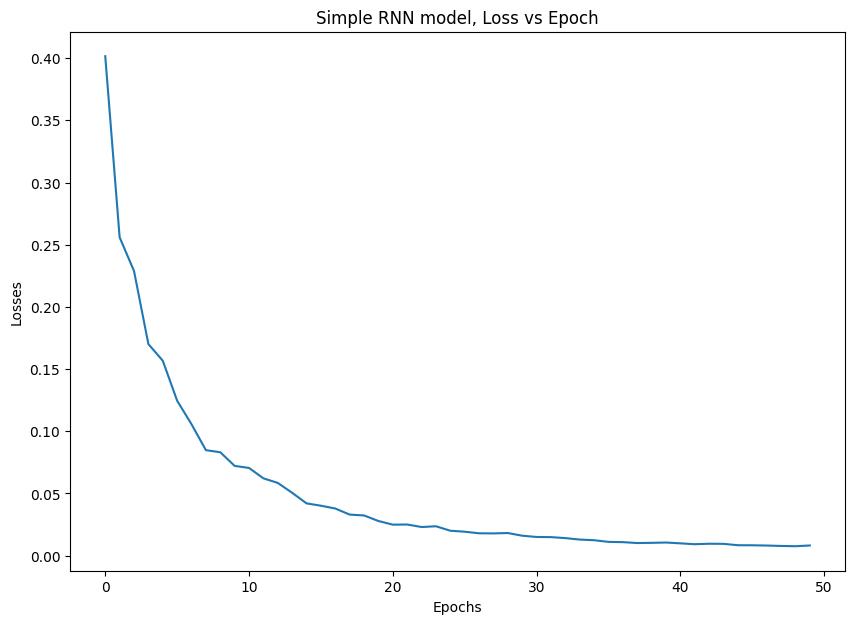

In [20]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

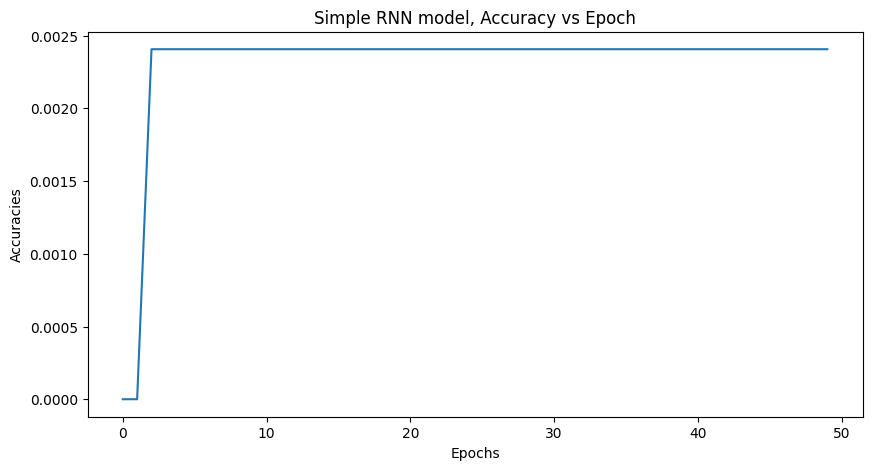

In [21]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

## Model predictions for train data

In [36]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(845, 1)

In [37]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(845, 1)

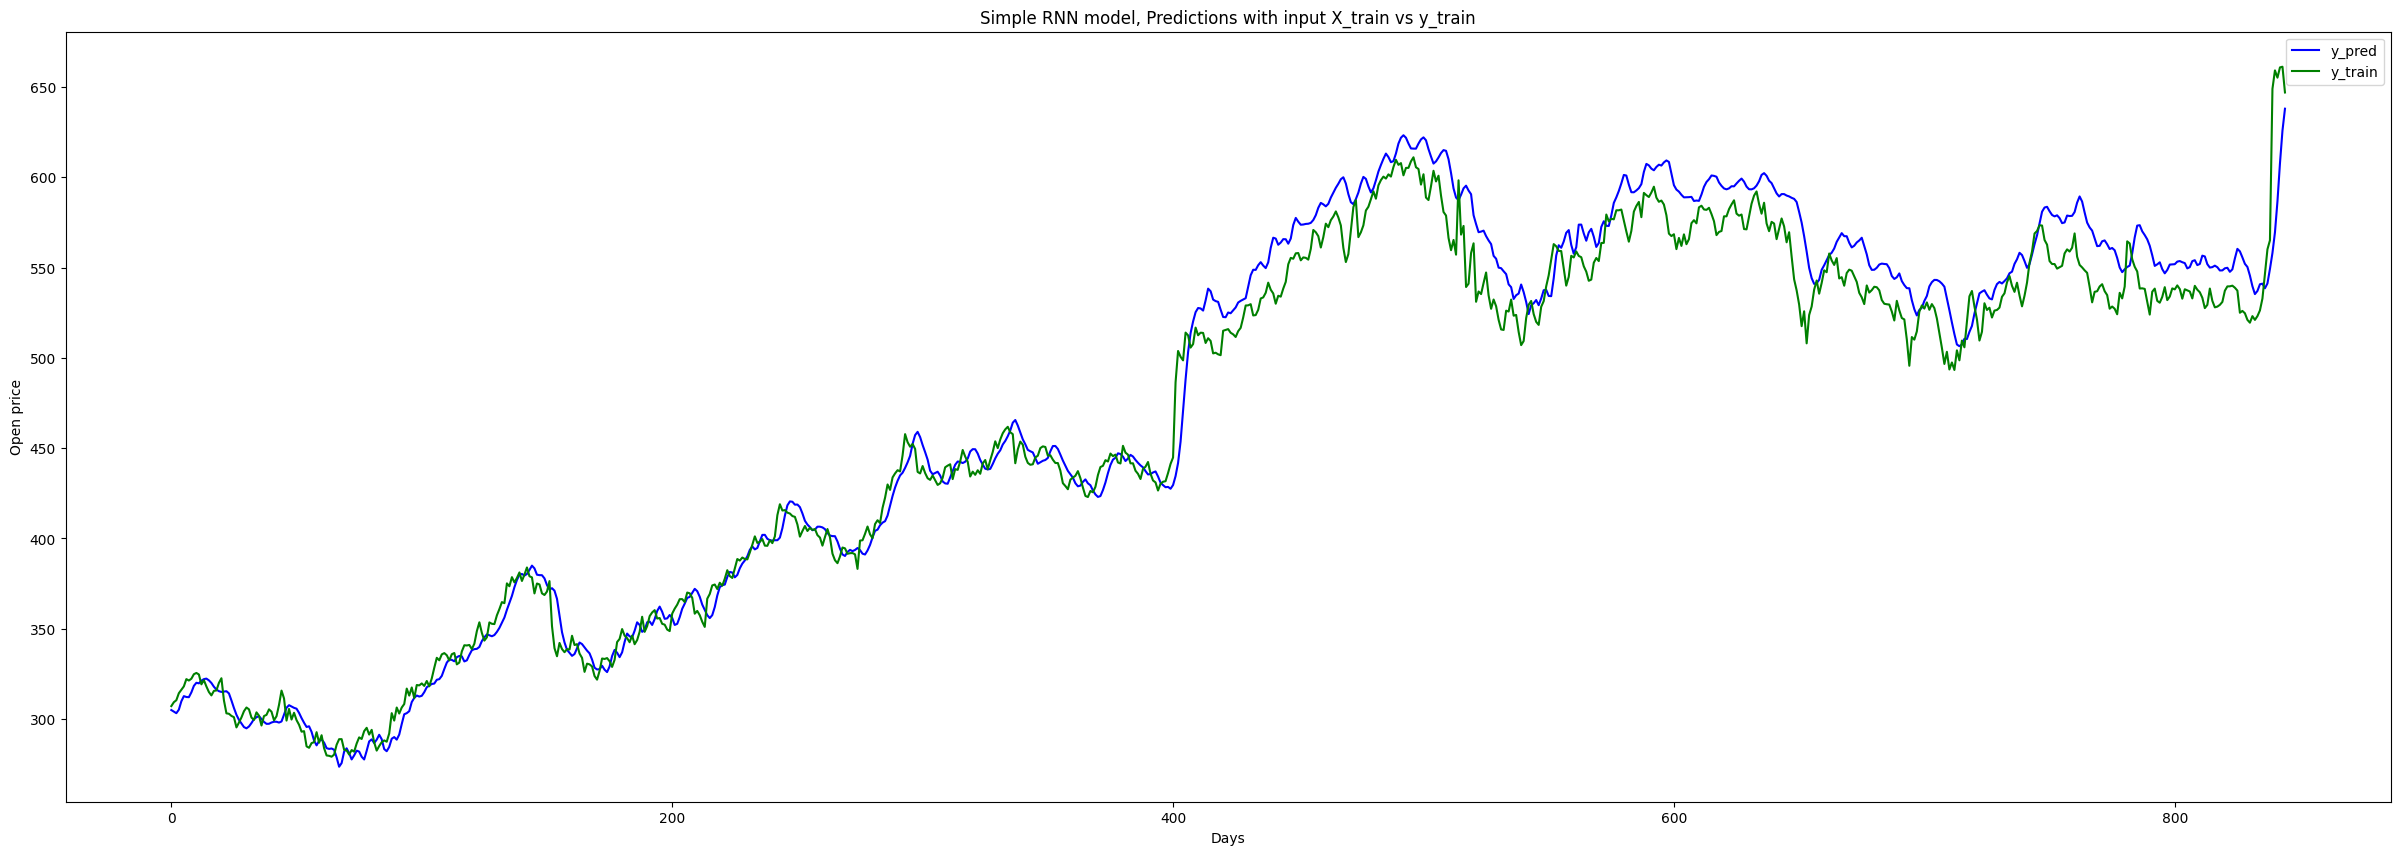

In [38]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()


<a id="8"></a>
## 8.Creating Test Dataset from Validation Data

In [39]:
dataset_validation = validation_data.Open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (383, 1)


### Creating X_test and y_test

In [40]:
X_test,y_test = create_sequence(scaled_dataset_validation, time_step)

In [42]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (333, 50)
Shape of y_test before reshape : (333,)


In [43]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [44]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (333, 50, 1)
Shape of y_test after reshape : (333, 1)


<a id="9"></a>
## 9.Evaluating with Validation Data

In [67]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test)
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Shape of y_pred_of_test : (333, 1)


In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
regressor_mae = mean_absolute_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred_of_test))
regressor_mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred_of_test))
regressor_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred_of_test)))
regressor_r2 = r2_score(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred_of_test))


print("Comparison of performace metrics")
print("Simple RNN")
print(regressor_mae, regressor_mse, regressor_rmse, regressor_r2)

Comparison of performace metrics
Simple RNN
0.06002942802886652 0.006205477199157057 0.07877485131155157 0.7224511708300415


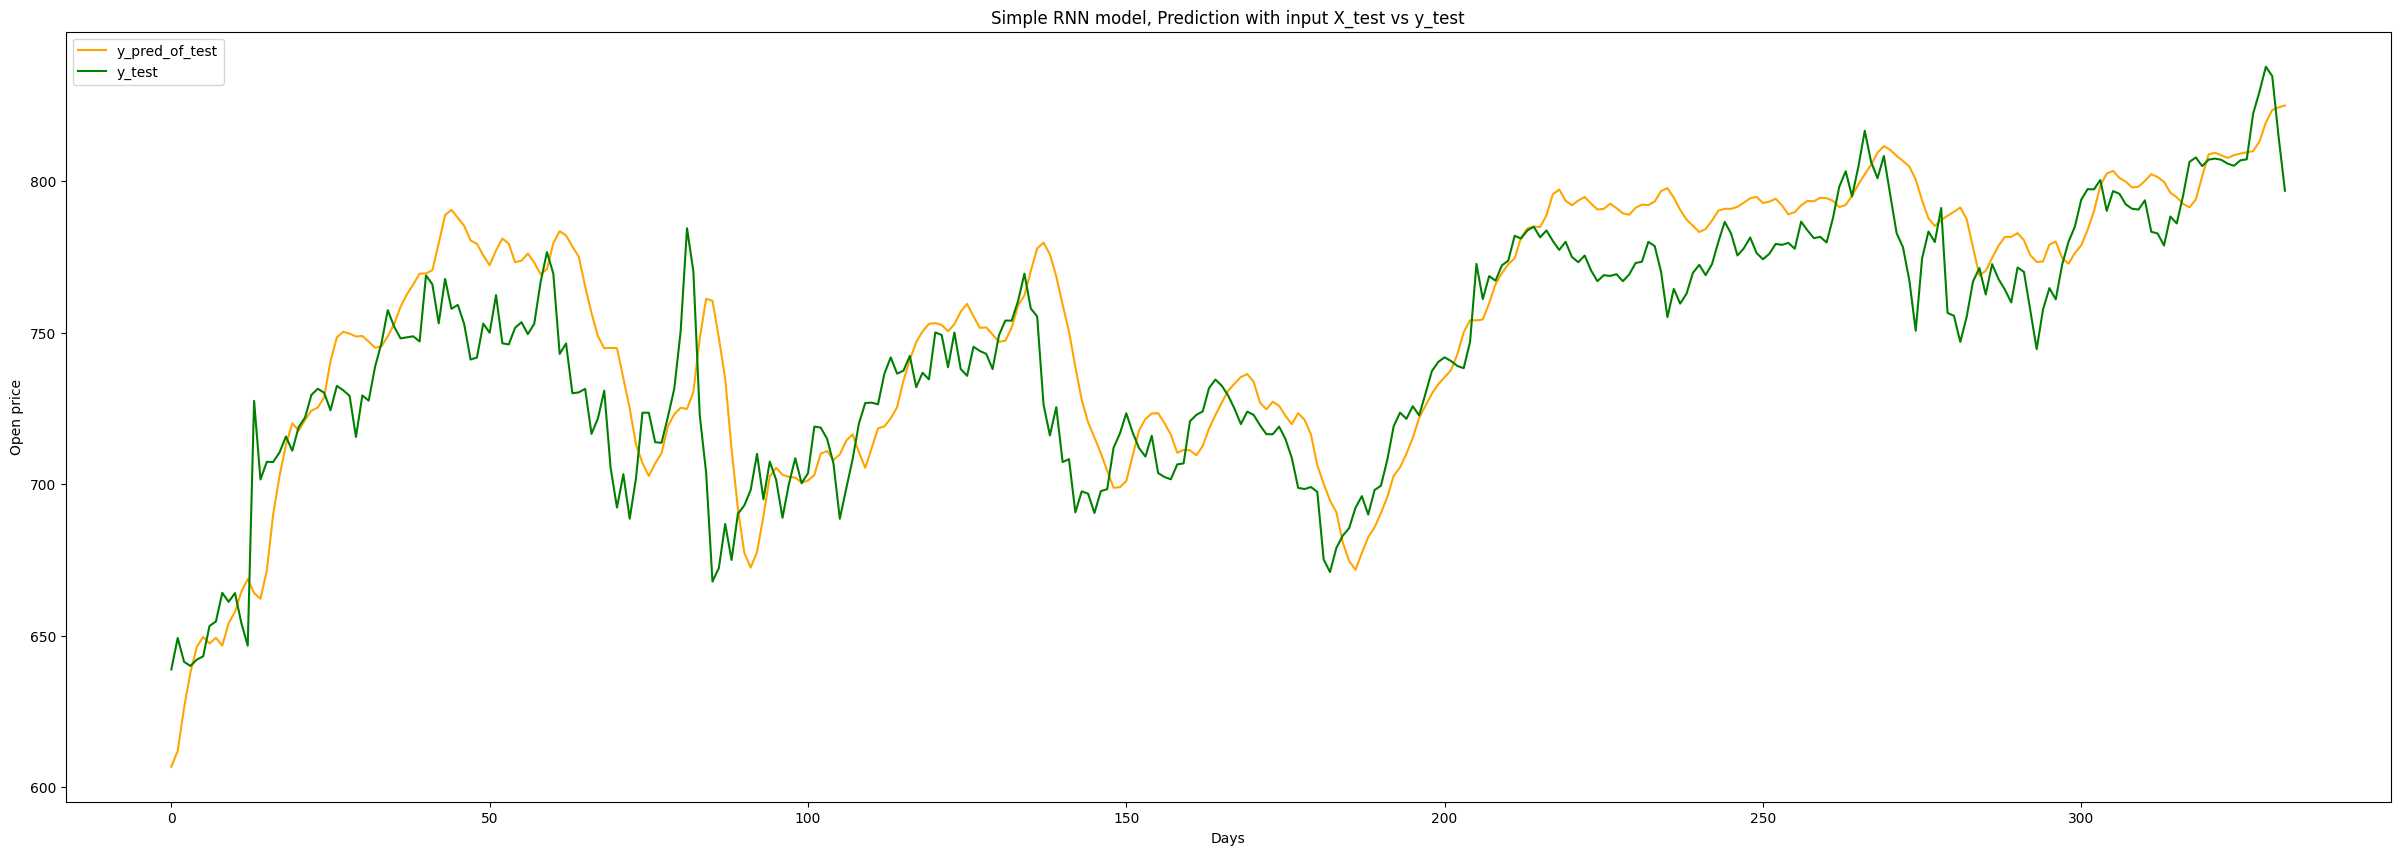

In [46]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

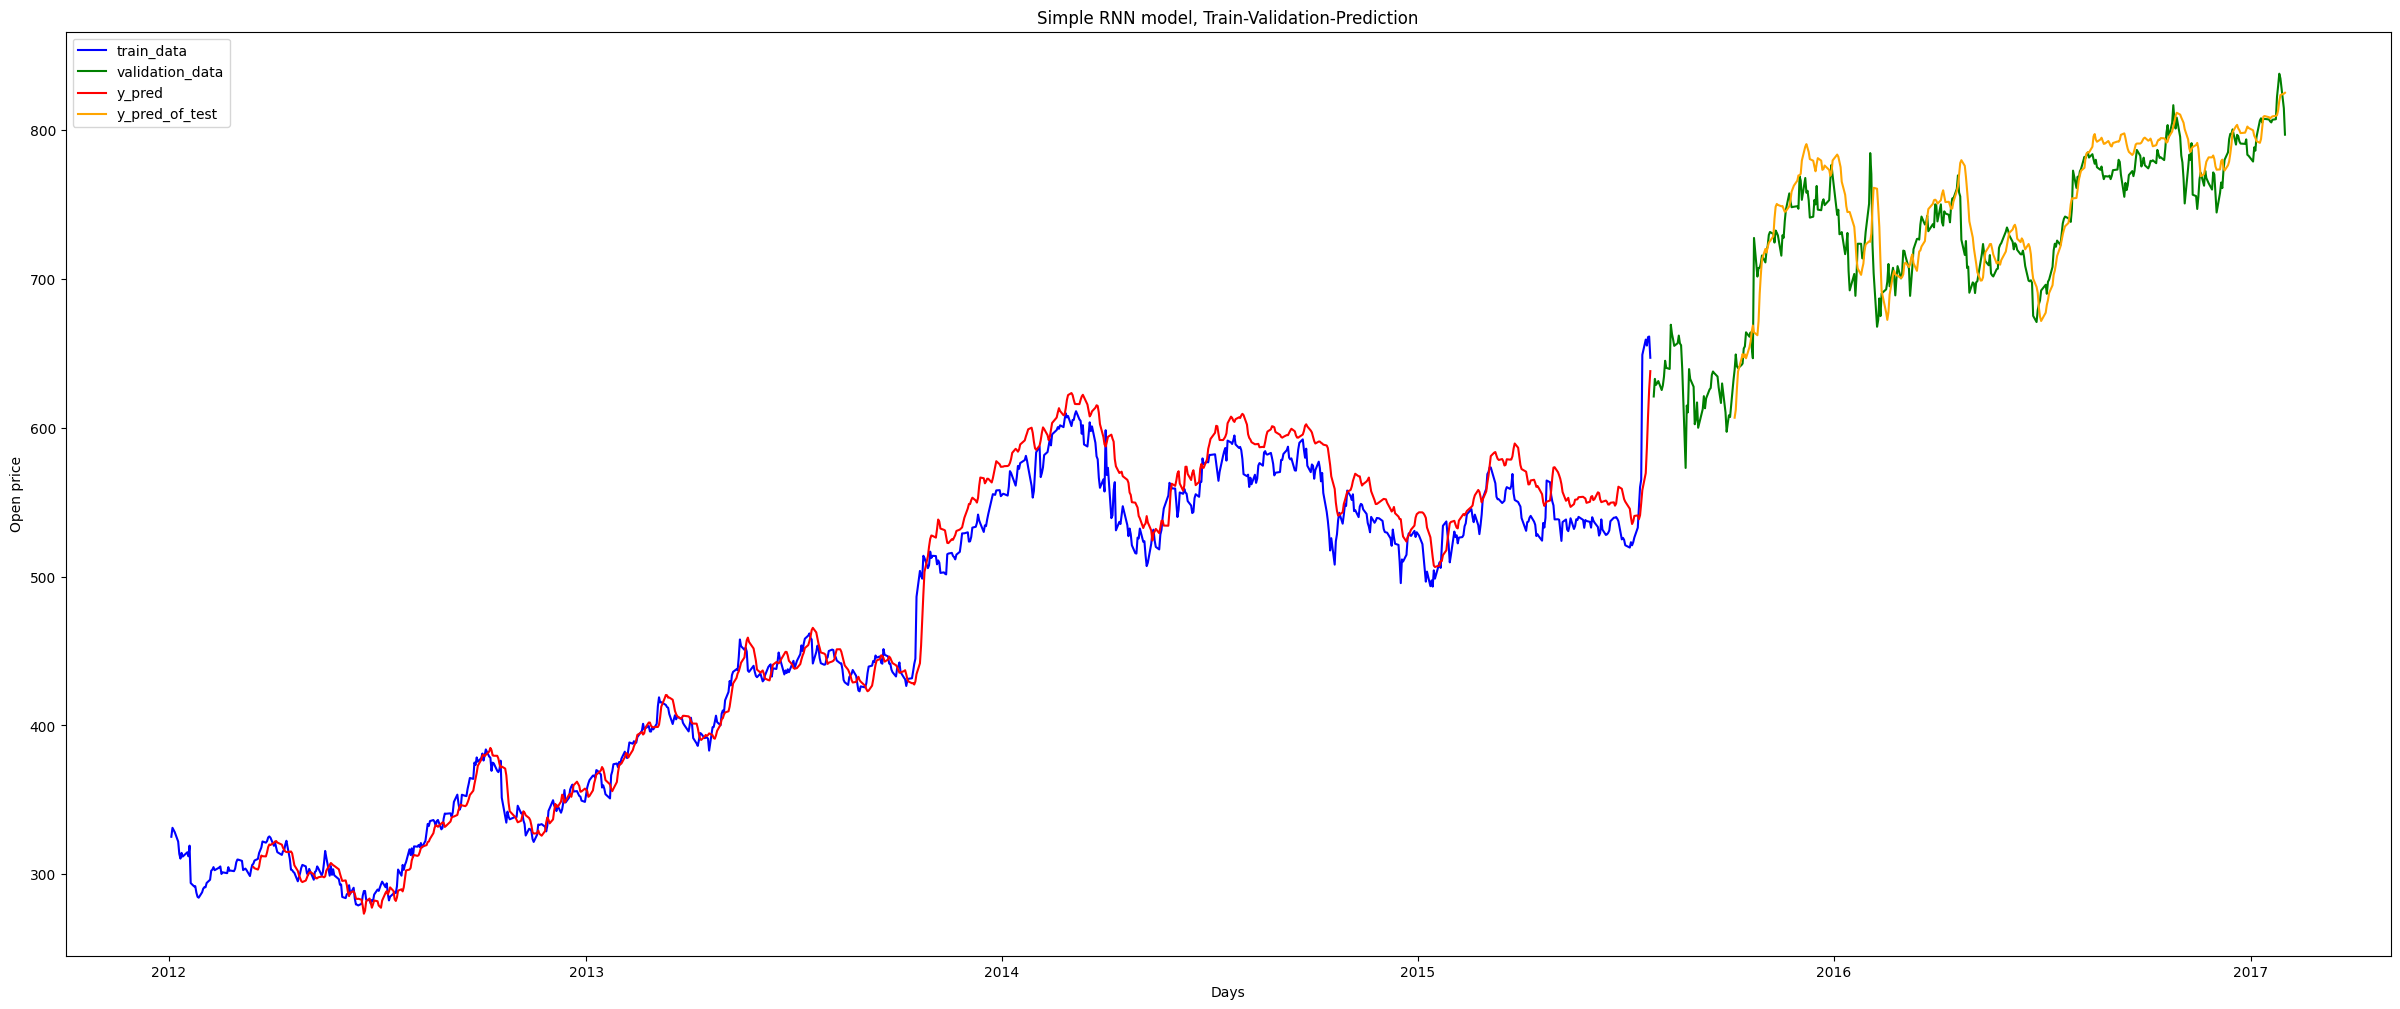

In [47]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

<a id="10"></a>
## 10.Creating LSTM Model

In [48]:
y_train = scaler.fit_transform(y_train)

In [49]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0011 - loss: 0.0308
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 7.3866e-04 - loss: 0.0022
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0029 - loss: 0.0021
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0014 - loss: 0.0020
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0027 - loss: 0.0014
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.0014 - loss: 0.0014
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0024 - loss: 0.0013
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0013 - loss: 0.0011
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0016 - loss: 8.8430e-04
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.0010 - loss: 0.0012


<a id="11"></a>
## 11.Evaluating LSTM Model

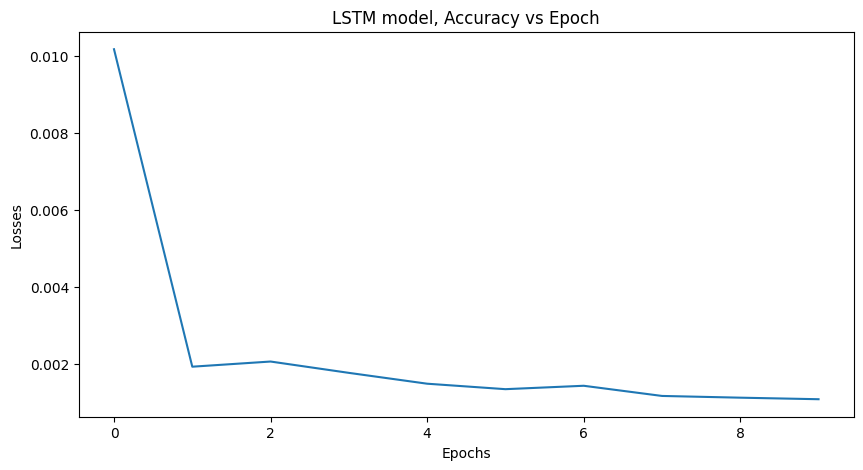

In [50]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


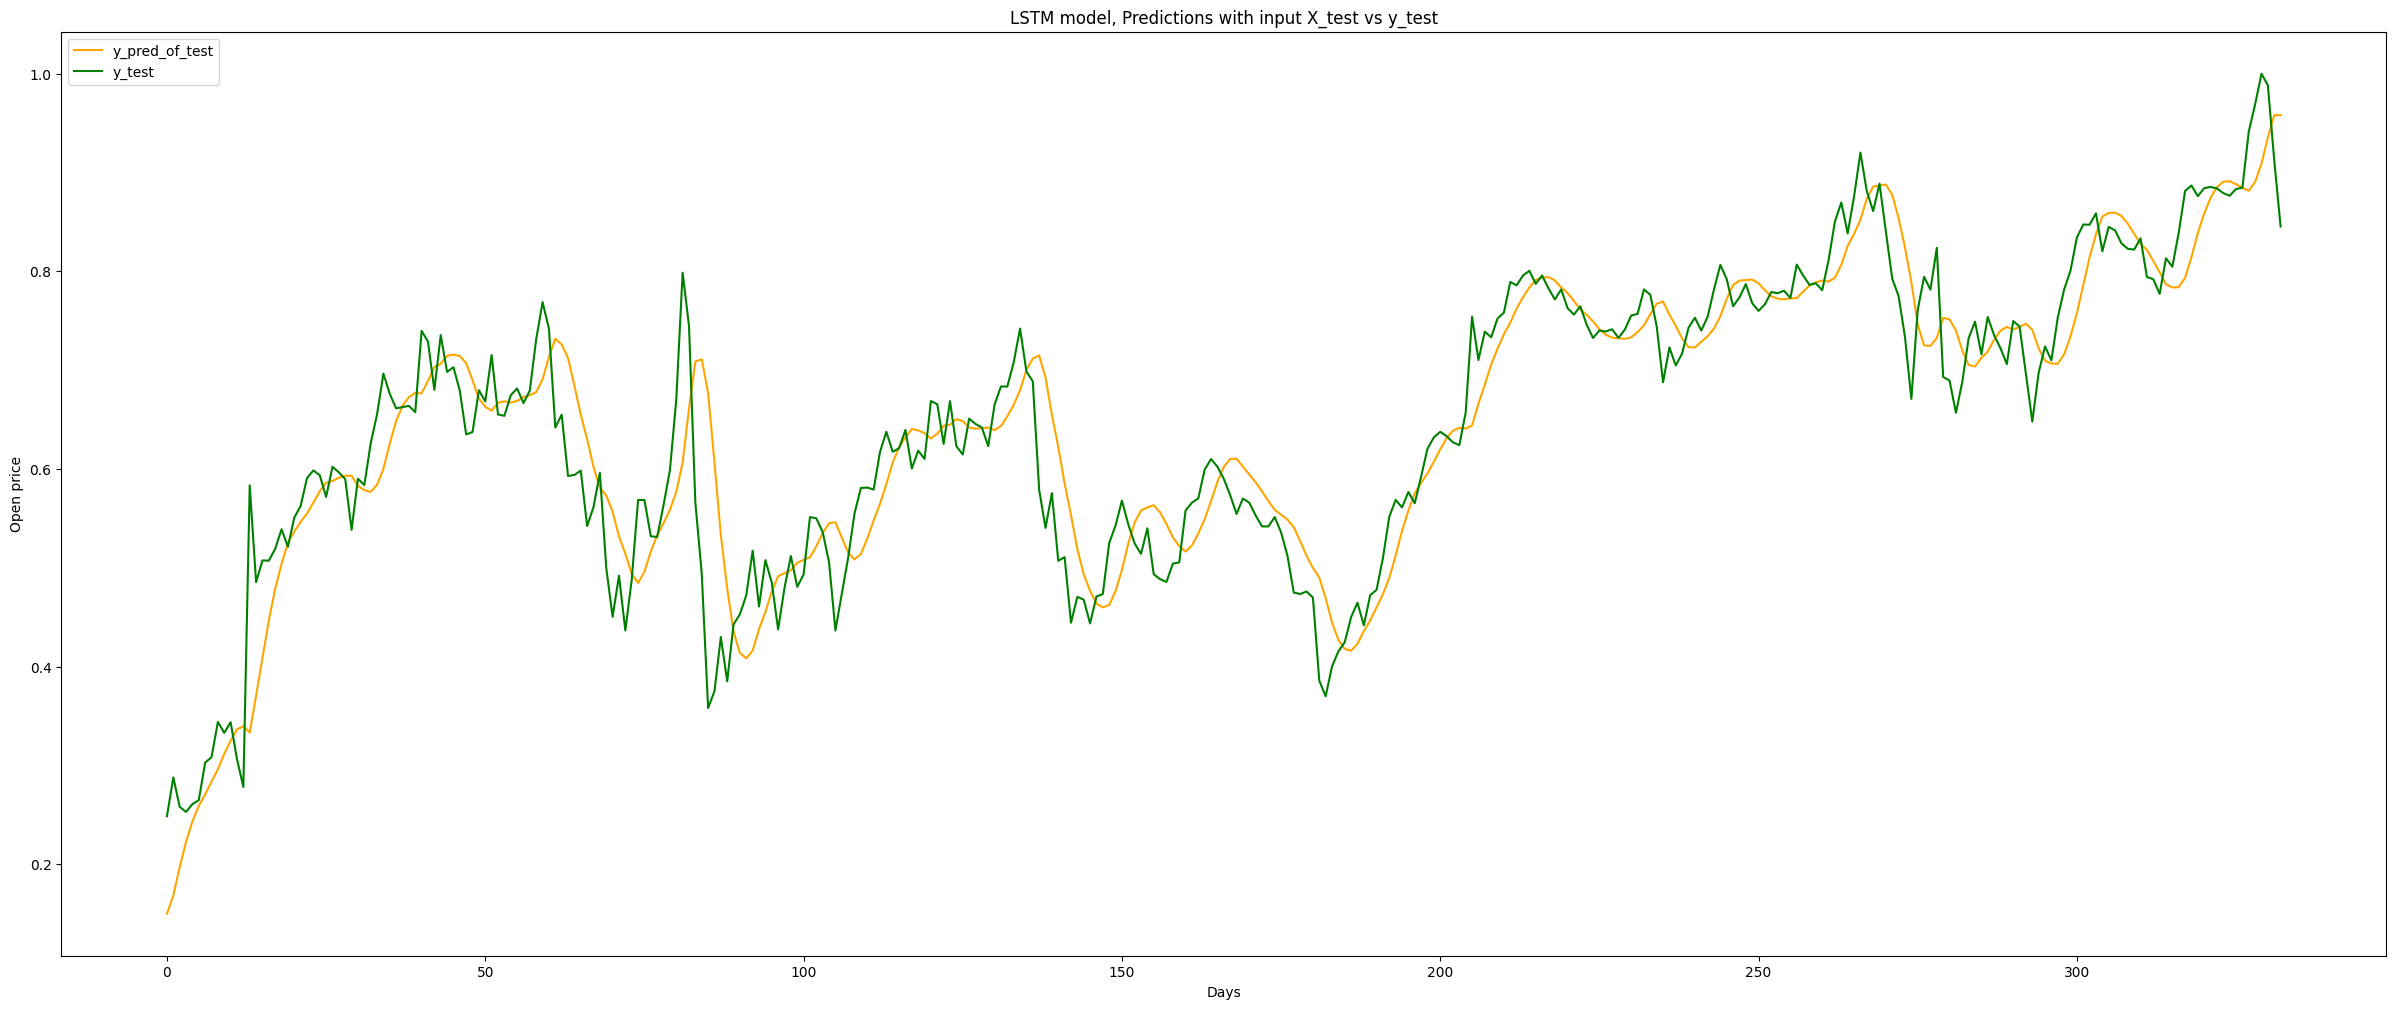

In [63]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

## Model evaluation

In [69]:
# predictions with X_test data
y_pred_of_test = model_lstm.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test)
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Shape of y_pred_of_test : (333, 1)


In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
regressor_mae = mean_absolute_error(scaler.inverse_transform(y_test), y_pred_of_test)
regressor_mse = mean_squared_error(scaler.inverse_transform(y_test), y_pred_of_test)
regressor_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), y_pred_of_test))
regressor_r2 = r2_score(scaler.inverse_transform(y_test), y_pred_of_test)


print("Comparison of performace metrics")
print("Simple LSTM")
print(regressor_mae, regressor_mse, regressor_rmse, regressor_r2)

Comparison of performace metrics
Simple RNN
0.03517383134020976 0.0021439936760974956 0.046303279323364296 0.9041068212079665


<a id="12"></a>
## 12.Future price prediction

In [54]:
data.iloc[-1]

,19
Date,1/31/2017
Open,796.86
High,801.25
Low,790.52
Close,796.79
Volume,"2,160,600"


In [52]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.23954087],
        [0.28727741],
        [0.19330616],
        [0.30079382],
        [0.24822999],
        [0.21100622],
        [0.16530787],
        [0.28899378],
        [0.2733319 ],
        [0.13784596],
        [0.        ],
        [0.14074233],
        [0.21604806],
        [0.17603519],
        [0.29918472],
        [0.37985411],
        [0.43391976],
        [0.52896374],
        [0.56650933],
        [0.56586569],
        [0.59869127],
        [0.48948723],
        [0.55964385],
        [0.54977473],
        [0.51244368],
        [0.49678181],
        [0.4944218 ],
        [0.52681828],
        [0.41557606],
        [0.40935422],
        [0.36708861],
        [0.46953443],
        [0.44507616],
        [0.54355289],
        [0.66305514],
        [0.67871701],
        [0.6480369 ],
        [0.67099335],
        [0.67464064],
        [0.67034971],
        [0.65672602],
        [0.64932418],
        [0.66852607],
        [0.67217335],
        [0.83361939],
        [0

In [53]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 31/01/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 31/01/2017 :", LSTM_prediction[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Simple RNN, Open price prediction for 3/18/2017      : 828.6042
LSTM prediction, Open price prediction for 3/18/2017 : 822.65955


## 12. Building a GRU model

In [55]:
y_train = scaler.fit_transform(y_train)

In [56]:
from keras.layers import GRU

model_gru = Sequential()
model_gru.add(
    GRU(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_gru.add(
    GRU(64, return_sequences= False))
model_gru.add(Dense(32))
model_gru.add(Dense(1))
model_gru.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_gru.fit(X_train, y_train, epochs = 10, batch_size = 10)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.0011 - loss: 0.0377
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 7.7696e-04 - loss: 6.8735e-04
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 5.0291e-04 - loss: 8.5964e-04
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.0019 - loss: 6.1227e-04
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0011 - loss: 6.2839e-04
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 7.4307e-04 - loss: 6.2117e-04
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.0017 - loss: 4.7513e-04
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.0012 - loss: 5.8036e-04
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.0015 - loss: 3.6614e-04
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.0016 - loss: 5.1260e-04


<a id="11"></a>
## 11.Evaluating GRU Model

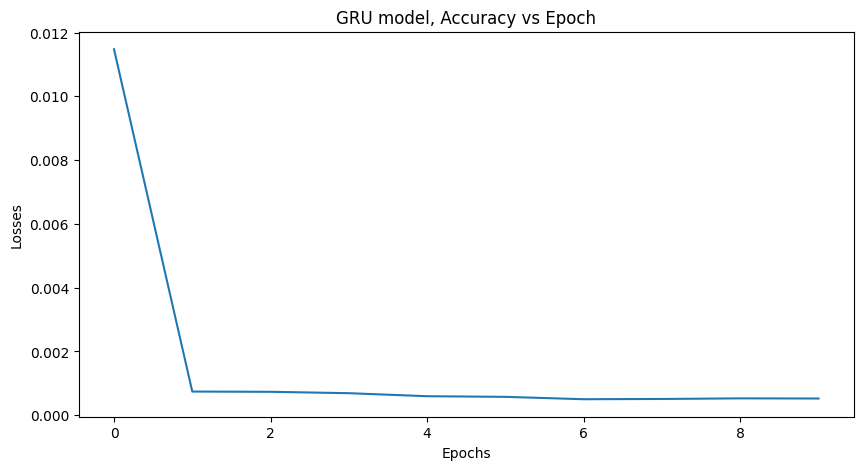

In [57]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("GRU model, Accuracy vs Epoch")
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


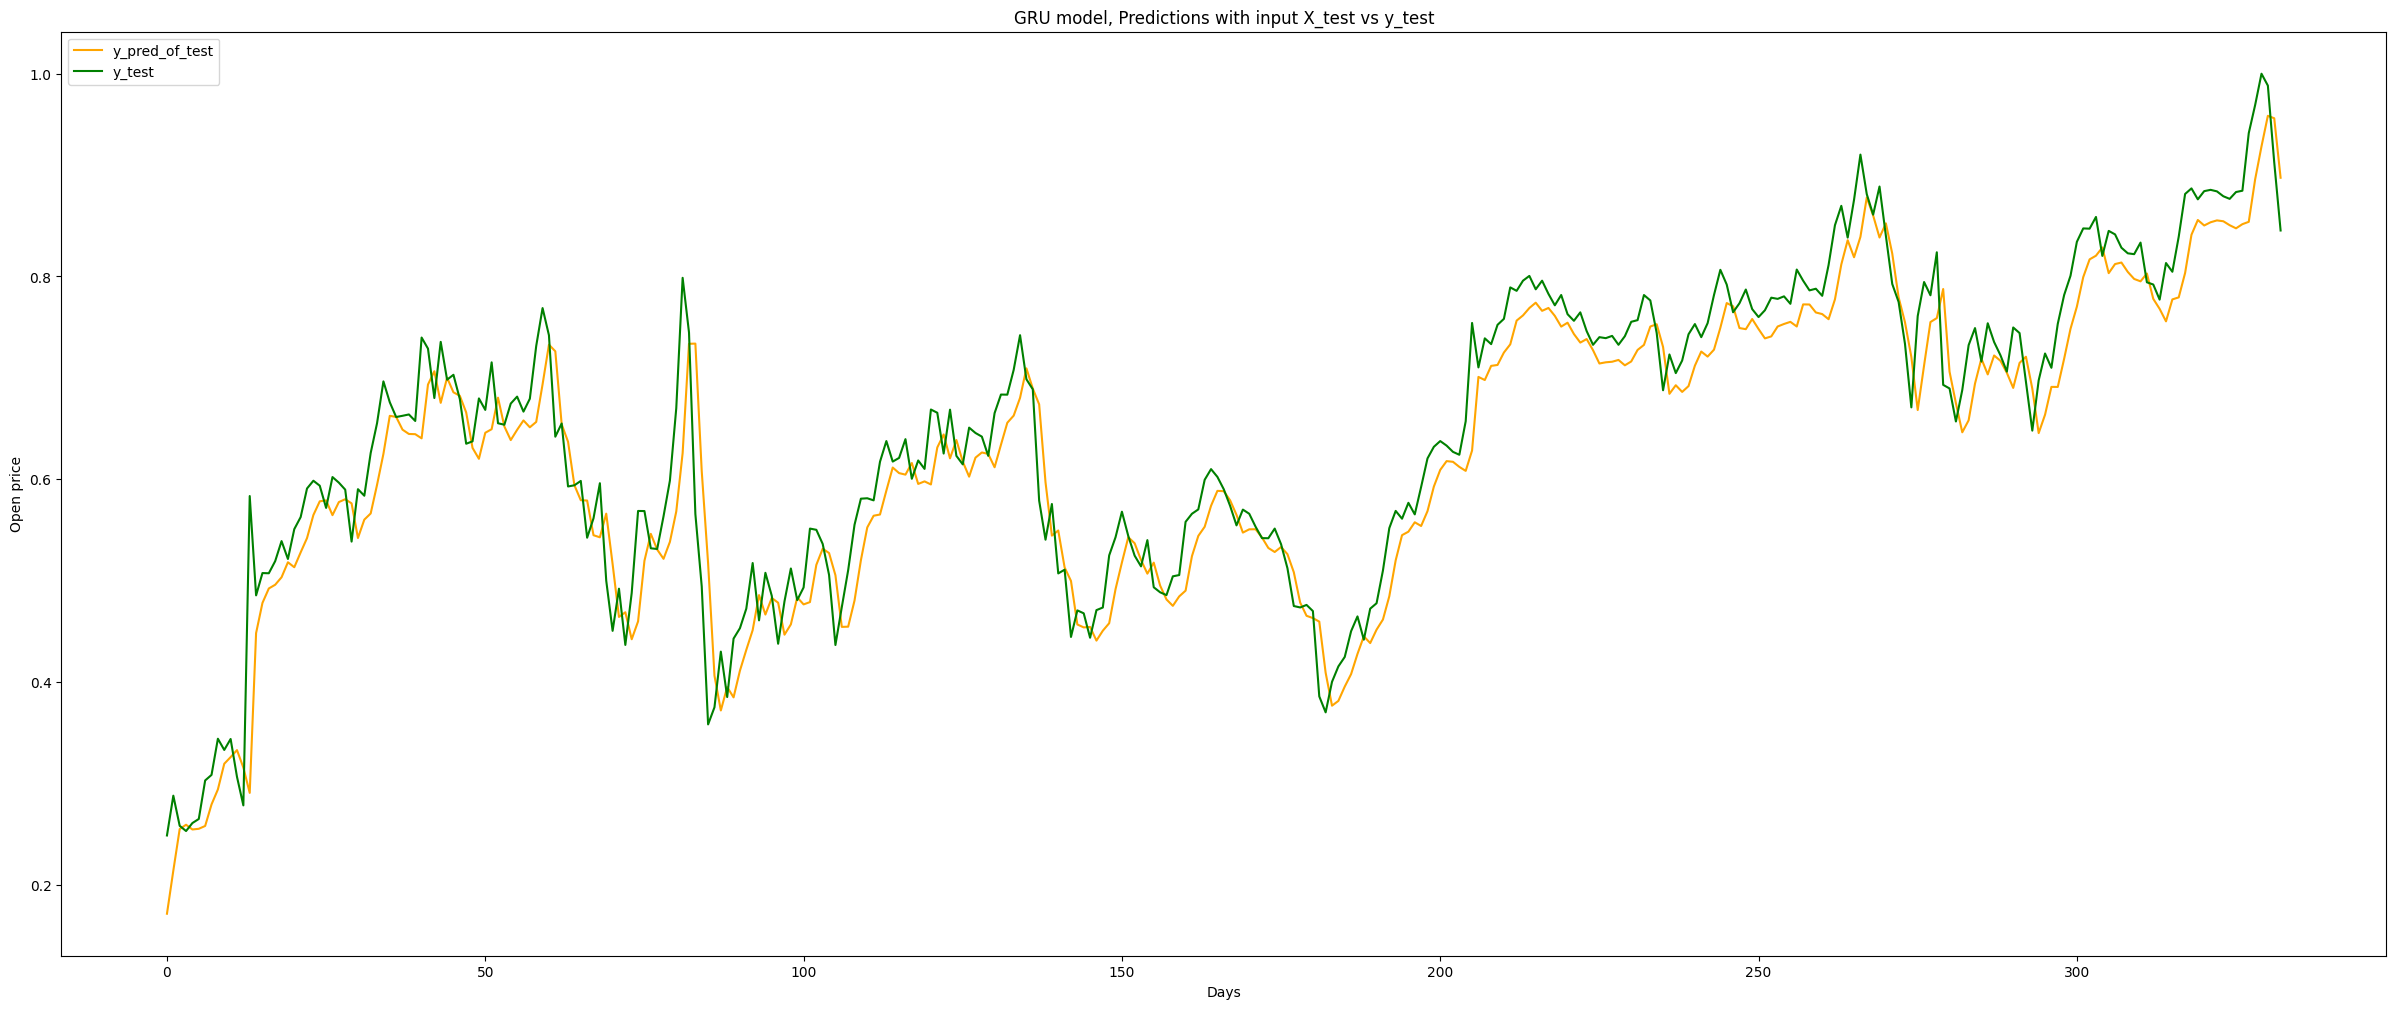

In [58]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_gru.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("GRU model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

## Prediction comparison

In [59]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
GRU_prediction = scaler.inverse_transform(model_gru.predict(X_input))
print("Simple RNN, Open price prediction for 31/01/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 31/01/2017 :", LSTM_prediction[0,0])
print("GRU prediction, Open price prediction for 31/01/2017   :", GRU_prediction[0,0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Simple RNN, Open price prediction for 31/01/2017      : 0.90124655
LSTM prediction, Open price prediction for 31/01/2017 : 0.83747596
GRU prediction, Open price prediction for 31/01/2017   : 0.60502064


## Comparison of evaluation metrics

In [71]:
# predictions with X_test data
y_pred_of_test = model_gru.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test)
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Shape of y_pred_of_test : (333, 1)


In [72]:

gru_mae = mean_absolute_error(scaler.inverse_transform(y_test), y_pred_of_test)
gru_mse = mean_squared_error(scaler.inverse_transform(y_test), y_pred_of_test)
gru_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), y_pred_of_test))
gru_r2 = r2_score(scaler.inverse_transform(y_test), y_pred_of_test)

In [75]:
print("Performance measures of GRU")
print(gru_mae, gru_mse, gru_rmse, gru_r2)


Performance measures of GRU
0.03517383134020976 0.0021439936760974956 0.046303279323364296 0.9041068212079665


In [79]:
print(f"| Metric | Simple RNN | LSTM | GRU |\n|---|---|---|---| \n| MAE | {regressor_mae} | {gru_mae} | {gru_mae} |\n| MSE | {regressor_mse} | {gru_mse} | {gru_mse} |\n| RMSE | {regressor_rmse} | {gru_rmse} | {gru_rmse} |\n| R2 | {regressor_r2} | {gru_r2} | {gru_r2} |")

| Metric | Simple RNN | LSTM | GRU |
|---|---|---|---| 
| MAE | 0.03517383134020976 | 0.03517383134020976 | 0.03517383134020976 |
| MSE | 0.0021439936760974956 | 0.0021439936760974956 | 0.0021439936760974956 |
| RMSE | 0.046303279323364296 | 0.046303279323364296 | 0.046303279323364296 |
| R2 | 0.9041068212079665 | 0.9041068212079665 | 0.9041068212079665 |


## Comparison table of performance metrics


| Metric | Simple RNN | LSTM | GRU |
|---|---|---|---|
| MAE | 0.03517383134020976 | 0.03517383134020976 | 0.03517383134020976 |
| MSE | 0.0021439936760974956 | 0.0021439936760974956 | 0.0021439936760974956 |
| RMSE | 0.046303279323364296 | 0.046303279323364296 | 0.046303279323364296 |
| R2 | 0.9041068212079665 | 0.9041068212079665 | 0.9041068212079665 |